In [5]:
!pip install yfinance

In [15]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [9]:
def BackTest(serie, annualiazed_scalar=252):

  # Importar el benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Cambiar el nombre
  sp500.name = "SP500"

  # Concatenar los retornos y el sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Calcular el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calcular el max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown en %", size=11)

  # Plot the graph
  plt.show()


  # Calcular el índice sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Calcular el índice  beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Calcular el índice  alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir los estadísticos
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")
     

In [19]:

def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


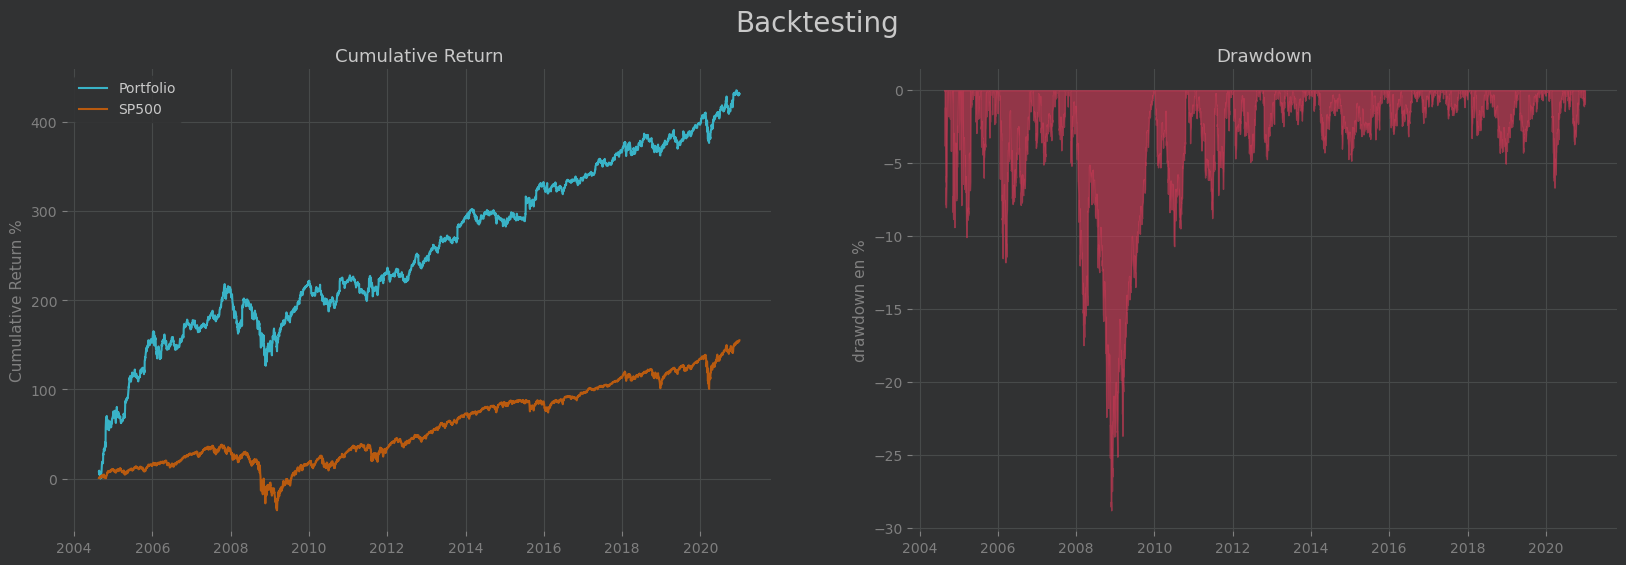

Sortino: 1.232
Beta: 0.965
Alpha: 0.918 %
MaxDrawdown: 28.78 %


In [21]:
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

BackTest(return_serie, annualiazed_scalar=252)


In [23]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=06d5620e35f0d61825dcf89c86bcd5226ed5ddd722affcdfa23d4ece81978aea
  Stored in directory: c:\users\usuario\appdata\local\pip\cache\wheels\a1\d7\29\7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [25]:
def SMA_strategy(input, mt5=False, yf=False):

  if mt5:
    df = preprocessing(input)
  
  if yf:
    df = preprocessing_yf(input)

  
  # Create Resistance using a rolling max
  df["SMA fast"] = df["close"].rolling(30).mean()

  # Create Support using a rolling min
  df["SMA slow"] = df["close"].rolling(60).mean()

  df["position"] = np.nan

  # Create the condition
  df.loc[(df["SMA fast"] > df["SMA slow"]) , "position"] = 1
  df.loc[(df["SMA fast"] < df["SMA slow"]) , "position"] = -1

  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy

  df["return"] = df["pct"] * (df["position"].shift(1))
  

  return df["return"]

def preprocessing_yf(symbol):
  
  #Import the data
  df = yf.download("EURUSD=X").dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df

def preprocessing(name):
  
  # Import the data
  df = pd.read_csv(name, delimiter="\t", index_col="", parse_dates=True)

  # Delete the two last columns
  df = df.iloc[:,:-2]

  # Rename
  df.columns = ["open", "high", "low", "close", "volume"]
  df.index.name = "time"

  return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


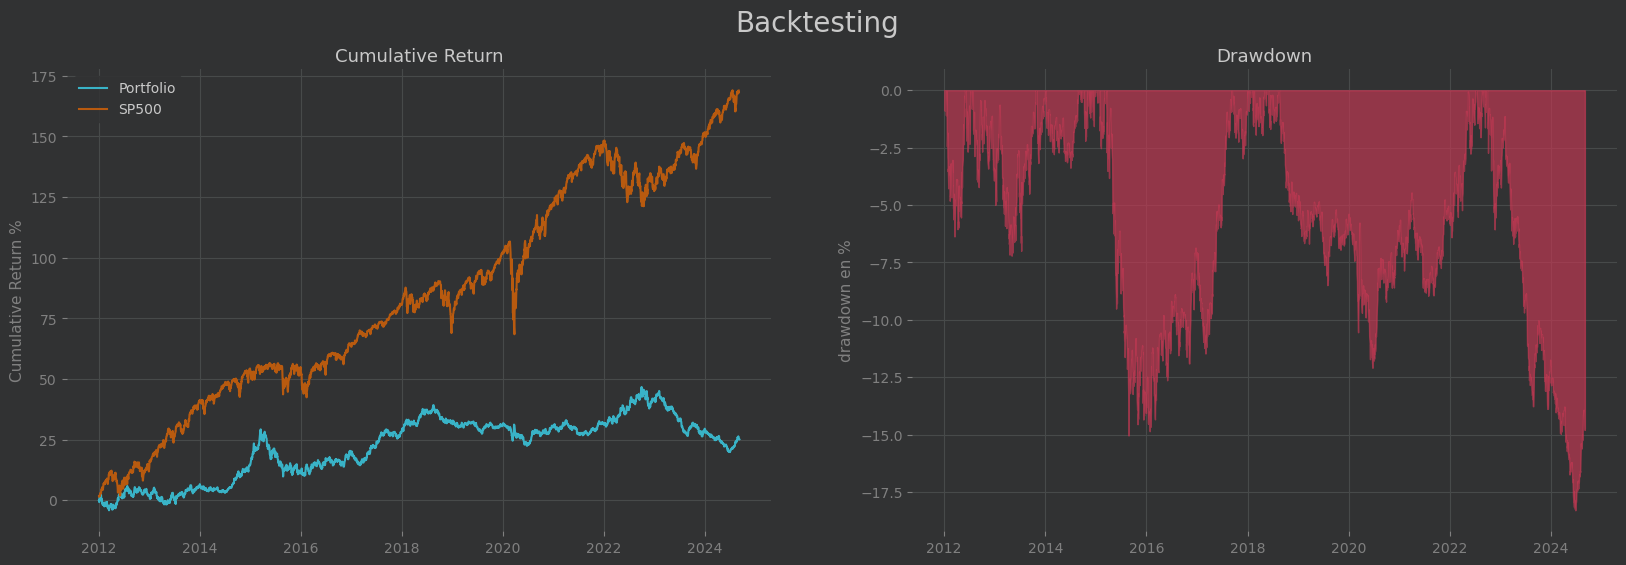

Sortino: 0.374
Beta: -0.004
Alpha: 1.922 %
MaxDrawdown: 18.301 %


In [43]:
dfc = SMA_strategy("EURUSD=X", yf=True).loc["2012":]-0.00001
BackTest(dfc,252)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


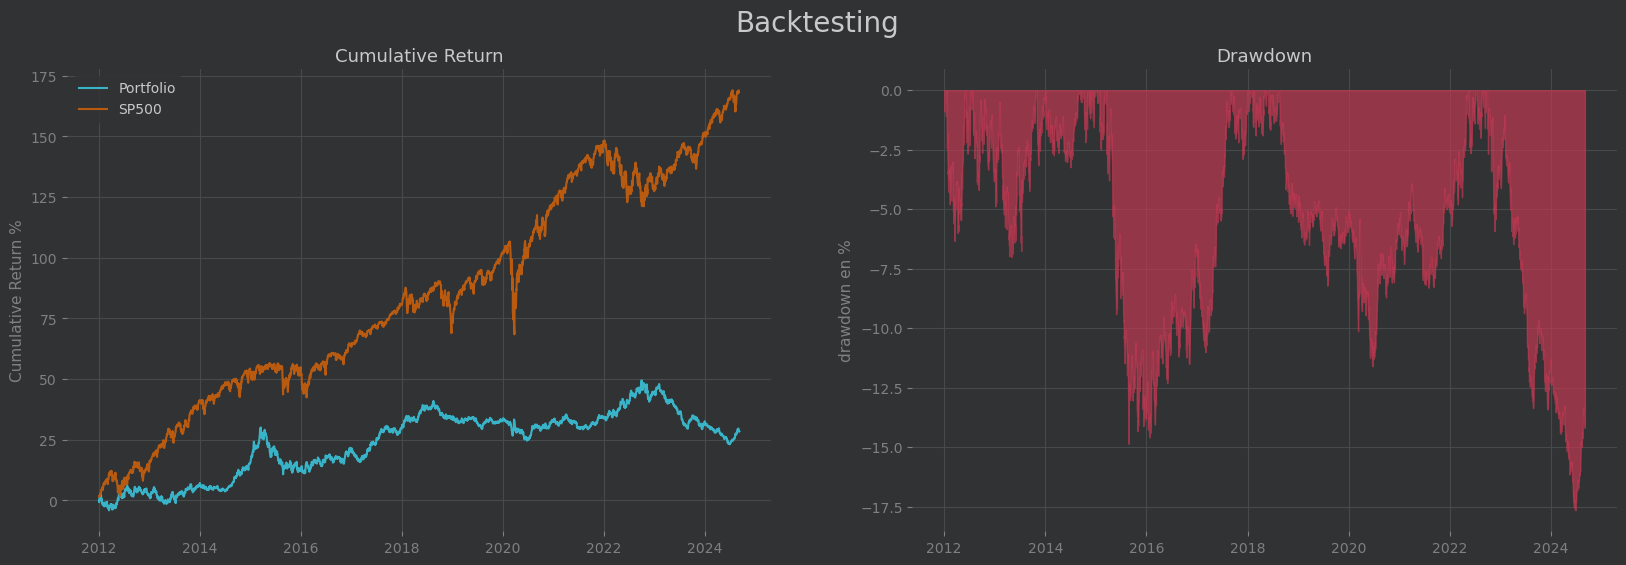

Sortino: 0.424
Beta: -0.004
Alpha: 2.175 %
MaxDrawdown: 17.653 %
